## Task 2
### Creating the XOR Dataset

We do the necessary imports and create the XOR dataset with points between 6 and - 6 (Similar to the TensorFlow Playgound Dataset). We generate 200 sam0ples of test data and 200 samples of train data.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(60)
def generate_xor_dataset(n_samples=200):
    
    x1 = np.random.rand(n_samples) * 12 - 6 
    x2 = np.random.rand(n_samples) * 12 - 6  
    y = np.logical_xor(x1 > 0, x2 > 0).astype(int)  
    return np.column_stack((x1, x2)), y

X_train, y_train = generate_xor_dataset()
X_test, y_test = generate_xor_dataset()


We plot the training and testing dataset to analyse their similarity and differences

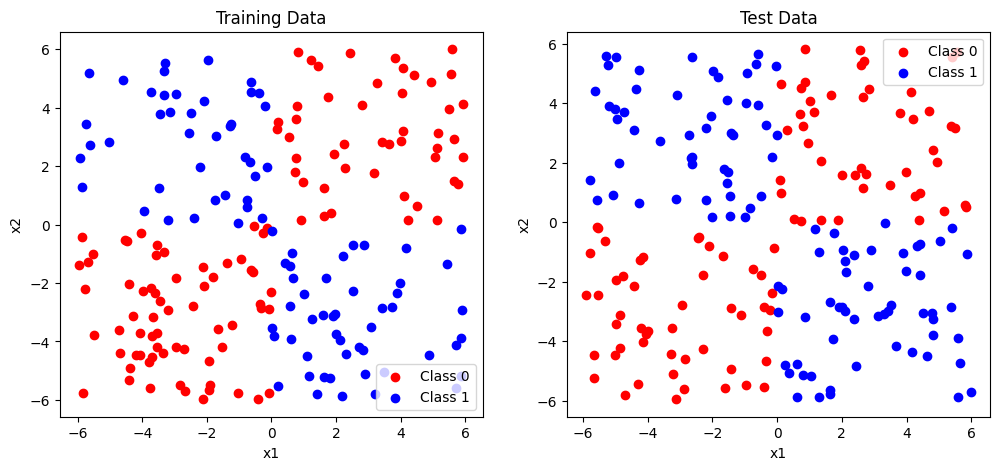

In [6]:
def plot_xor_data(X_train, y_train, X_test, y_test):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], color='red', label='Class 0')
    ax1.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], color='blue', label='Class 1')
    ax1.set_title("Training Data")
    ax1.set_xlabel("x1")
    ax1.set_ylabel("x2")
    ax1.legend()
    ax2.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], color='red', label='Class 0')
    ax2.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], color='blue', label='Class 1')
    ax2.set_title("Test Data")
    ax2.set_xlabel("x1")
    ax2.set_ylabel("x2")
    ax2.legend()
    plt.show()
plot_xor_data(X_train, y_train, X_test, y_test)


### Defining the MLP class

The MLP Class consist of 3 layers of neurons. The first layer is the input layer with 2 neurons for the given dataset and the ouput layers is one neuron telling us whther the object is class 0 or class 1. There is one hidden layer, whos enumber of neurons is a hyper parameter, in this case set to 5 neurons.

The output of the first layer is passed through the ReLU function (Activaation function). The output layer does not have an activation layer (ideally should have been sigmoid since we are performing a task of binary classification). The model outputs the probabilites of the classes instead. However, in the train model function defined below, we use Binary Cross entropy Loss with logits function on the model output and this loss calculated is used to train the model. 

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x


Function definiton for L1 penalty ( Delta = 0.01 by default)

In [8]:
def l1_penalty(model, lambda_l1=0.01):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return lambda_l1 * l1_norm

The train_model function is designed to train a neural network model using the provided dataset for a specified number of epochs. It begins by setting the model to training mode and iterates through each epoch, where it converts the input features and labels into PyTorch tensors. The optimizer gradients are reset, and the model's outputs are computed from the inputs. The loss is calculated using the specified criterion, and if L1 regularization is enabled, an additional penalty is added to the loss. The gradients are then backpropagated, and the model parameters are updated. Every 100 epochs, the training loss is printed. After training, the model is evaluated on a separate test dataset, where the outputs are passed through a sigmoid function to obtain class predictions. The accuracy of the model on the test set is then calculated and displayed as a percentage.

In [22]:
def train_model(model, criterion, optimizer, X, y,X_test = X_test,y_test = y_test, l1 = False, epochs=1000):
    model.train()
    for epoch in range(epochs):
        inputs = torch.tensor(X, dtype=torch.float32)
        labels = torch.tensor(y, dtype=torch.float32).view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        if l1:
            loss += l1_penalty(model)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch [{epoch}/{epochs}] - Training Loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        test_inputs = torch.tensor(X_test, dtype=torch.float32)
        test_labels = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
        test_outputs = model(test_inputs)
        test_preds = (torch.sigmoid(test_outputs) > 0.5).float()
        accuracy = (test_preds == test_labels).float().mean().item()
        print(f'Test Accuracy: {accuracy * 100:.2f}%')

### Model With No Regularisation

In [10]:
input_size = 2
hidden_size = 5
output_size = 1
epochs = 1000

mlp = MLP(input_size, hidden_size, output_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.01)

train_model(mlp, criterion, optimizer, X_train, y_train)

Epoch [0/1000] - Training Loss: 0.6323
Epoch [100/1000] - Training Loss: 0.1338
Epoch [200/1000] - Training Loss: 0.0800
Epoch [300/1000] - Training Loss: 0.0594
Epoch [400/1000] - Training Loss: 0.0484
Epoch [500/1000] - Training Loss: 0.0415
Epoch [600/1000] - Training Loss: 0.0366
Epoch [700/1000] - Training Loss: 0.0330
Epoch [800/1000] - Training Loss: 0.0301
Epoch [900/1000] - Training Loss: 0.0276
Test Accuracy: 98.50%


Function to plot the decision boundries learnt by model

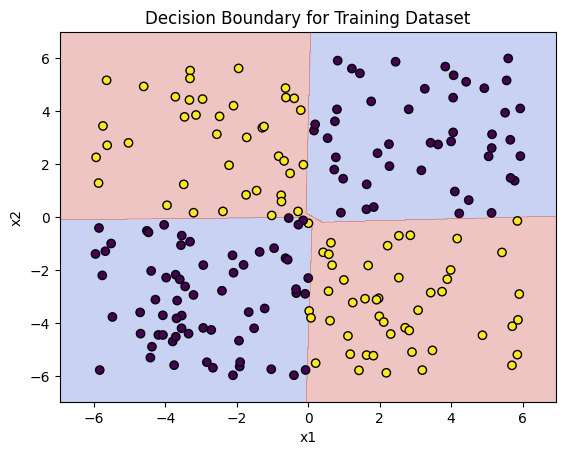

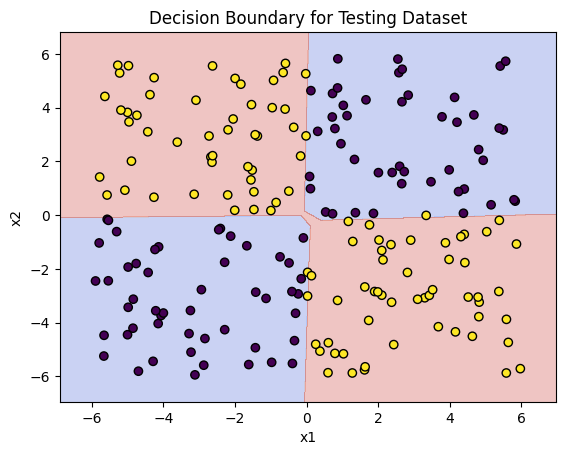

In [25]:
def plot_decision_boundary(model, X, y, title,lr = False):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    model.eval()
    with torch.no_grad():
        if lr:
            Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel(),(xx.ravel() ** 2),(xx.ravel() * yy.ravel()), (yy.ravel() ** 2),(xx.ravel() ** 3),((xx.ravel()**2) * yy.ravel()),(xx.ravel() * (yy.ravel()**2)), (yy.ravel() ** 3)], dtype=torch.float32))
        else:
            Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
        Z = torch.sigmoid(Z).numpy()
    
    Z = (Z > 0.5).astype(int)
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', marker='o')
    
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

plot_decision_boundary(mlp, X_train, y_train, "Decision Boundary for Training Dataset")
plot_decision_boundary(mlp, X_test, y_test, "Decision Boundary for Testing Dataset")


### Model With L1 Regularisation

In [12]:
mlpL1 = MLP(input_size, hidden_size, output_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(mlpL1.parameters(), lr=0.01)

train_model(mlpL1, criterion, optimizer, X_train, y_train,l1=True)

Epoch [0/1000] - Training Loss: 0.8271
Epoch [100/1000] - Training Loss: 0.4007
Epoch [200/1000] - Training Loss: 0.3398
Epoch [300/1000] - Training Loss: 0.3152
Epoch [400/1000] - Training Loss: 0.2635
Epoch [500/1000] - Training Loss: 0.2449
Epoch [600/1000] - Training Loss: 0.2352
Epoch [700/1000] - Training Loss: 0.2331
Epoch [800/1000] - Training Loss: 0.2326
Epoch [900/1000] - Training Loss: 0.2323
Test Accuracy: 99.00%


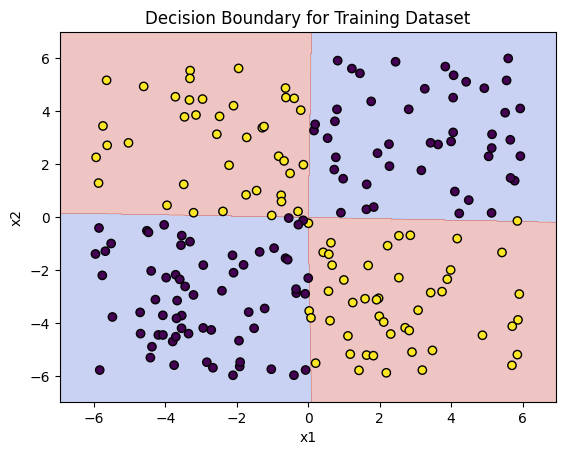

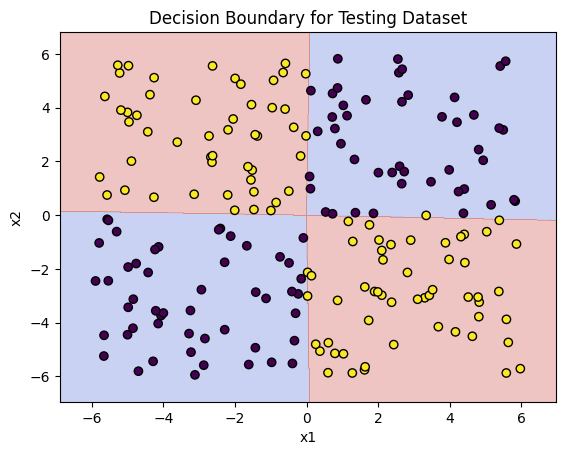

In [13]:
plot_decision_boundary(mlpL1, X_train, y_train, "Decision Boundary for Training Dataset")
plot_decision_boundary(mlpL1, X_test, y_test, "Decision Boundary for Testing Dataset")

### Model With L2 Regularisation

In [14]:

mlpL2 = MLP(input_size, hidden_size, output_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(mlpL2.parameters(), lr=0.01)
lambda_l2 = 0.01
optimizer = optim.Adam(mlpL2.parameters(), lr=0.01, weight_decay=lambda_l2)
train_model(mlpL2, criterion, optimizer, X_train, y_train)

Epoch [0/1000] - Training Loss: 0.8331
Epoch [100/1000] - Training Loss: 0.2675
Epoch [200/1000] - Training Loss: 0.1215
Epoch [300/1000] - Training Loss: 0.1044
Epoch [400/1000] - Training Loss: 0.0995
Epoch [500/1000] - Training Loss: 0.0975
Epoch [600/1000] - Training Loss: 0.0966
Epoch [700/1000] - Training Loss: 0.0962
Epoch [800/1000] - Training Loss: 0.0960
Epoch [900/1000] - Training Loss: 0.0959
Test Accuracy: 99.50%


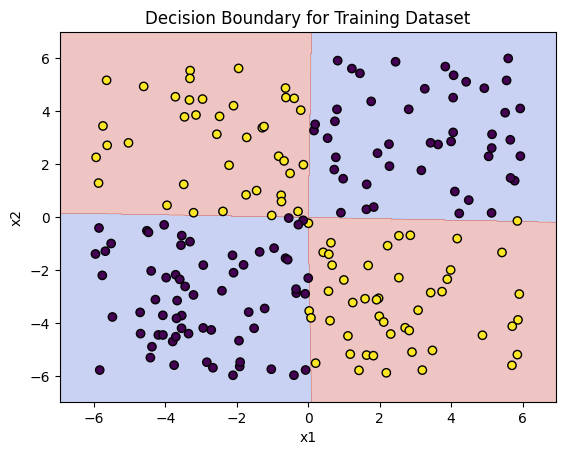

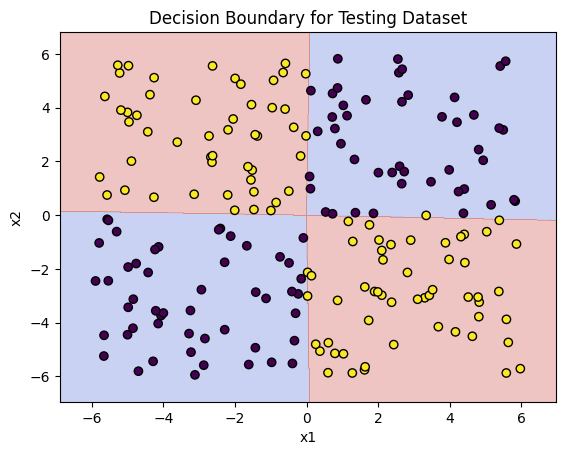

In [15]:
plot_decision_boundary(mlpL1, X_train, y_train, "Decision Boundary for Training Dataset")
plot_decision_boundary(mlpL1, X_test, y_test, "Decision Boundary for Testing Dataset")

### Logistic Regression Model

We create all polynomial features upto degree 3 using sklearn.preprocessing.PolynomilFeatures

In [29]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)


This LogisticModel class defines a logistic regression model in PyTorch with a single linear layer that takes in input features and outputs a single value. The forward method simply applies the linear transformation to the input data, producing logits that can be used for binary classification.

In [17]:
class LogisticModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

In [24]:
logReg = LogisticModel(9)
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(logReg.parameters(), lr=0.01)
train_model(logReg,criterion,optimizer,X_train_poly,y_train,X_test_poly,y_test)

Epoch [0/1000] - Training Loss: 6.2842
Epoch [100/1000] - Training Loss: 0.1468
Epoch [200/1000] - Training Loss: 0.1294
Epoch [300/1000] - Training Loss: 0.1160
Epoch [400/1000] - Training Loss: 0.1054
Epoch [500/1000] - Training Loss: 0.0968
Epoch [600/1000] - Training Loss: 0.0897
Epoch [700/1000] - Training Loss: 0.0838
Epoch [800/1000] - Training Loss: 0.0788
Epoch [900/1000] - Training Loss: 0.0745
Test Accuracy: 99.00%


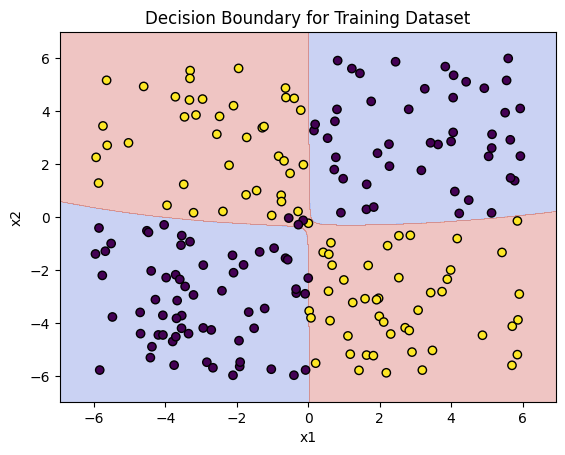

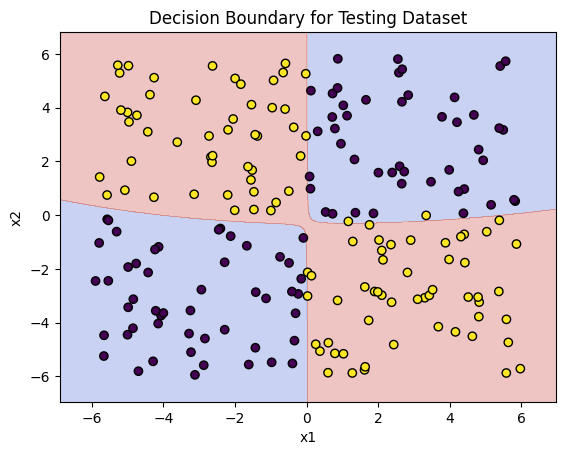

In [28]:
plot_decision_boundary(logReg,X_train_poly,y_train,"Decision Boundary for Training Dataset",lr=True)
plot_decision_boundary(logReg,X_test_poly,y_test,"Decision Boundary for Testing Dataset",lr=True)